In [603]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

import pickle

import statsmodels.api as sm
from sklearn import cross_validation, feature_selection, grid_search, linear_model            

In [604]:
with open("consolDF.pkl", 'rb') as picklefile: 
    df = pickle.load(picklefile)

df.columns

Index(['movie_title', 'gtr_domestic', 'gtr_foreign', 'gtr_opening',
       'open_ranking', 'widest_release', 'prod_budget', 'big_budget',
       'days_in_release', 'year_of_release', 'year_week_index',
       'total_world_sales', 'week_movies_out', 'week_overall_gross',
       'three_week_total', 'new_releases_in_same_week', 'three_week_opening',
       'three_week_opening_gtr', 'target'],
      dtype='object')

In [605]:
df['sales_cost_ratio'] = df['total_world_sales'] / df['prod_budget']
df['sales_cost_log'] = np.log(df['sales_cost_ratio'])
# # df['gross_margin_reverse_log'] = np.exp(df['gross_margin_log'])

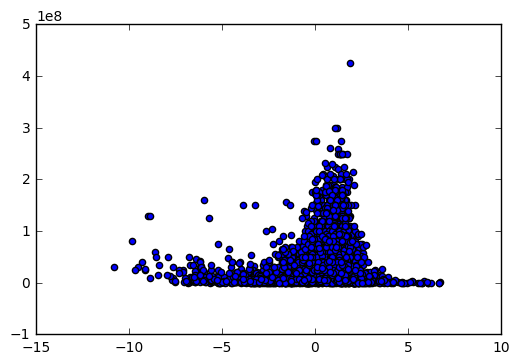

In [606]:
x = df['sales_cost_log']
y = df['prod_budget']

plt.scatter(x,y)
plt.show()

In [607]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [608]:
df = df.dropna()
a = list(df.columns)
b = list(df.isnull().sum(axis=0).tolist())
list(zip(a,b))

[('movie_title', 0),
 ('gtr_domestic', 0),
 ('gtr_foreign', 0),
 ('gtr_opening', 0),
 ('open_ranking', 0),
 ('widest_release', 0),
 ('prod_budget', 0),
 ('big_budget', 0),
 ('days_in_release', 0),
 ('year_of_release', 0),
 ('year_week_index', 0),
 ('total_world_sales', 0),
 ('week_movies_out', 0),
 ('week_overall_gross', 0),
 ('three_week_total', 0),
 ('new_releases_in_same_week', 0),
 ('three_week_opening', 0),
 ('three_week_opening_gtr', 0),
 ('target', 0),
 ('sales_cost_ratio', 0),
 ('sales_cost_log', 0)]

In [609]:
target = df['sales_cost_log']
target

3       -1.065297
6       -4.260985
9       -1.578673
12       0.775319
14       1.772684
15       0.691240
34      -0.506693
37       1.360811
42       0.476535
46      -1.757113
48       0.868992
51       0.797759
52       1.987482
61      -0.538812
69       1.924729
73      -0.251987
76       0.824301
77       0.869089
80       0.868857
81      -1.185537
92       1.883195
97       0.736767
100     -6.711108
104      0.388539
120      0.613877
121      3.914991
123     -5.639682
125      0.314162
134      1.676578
135     -6.435173
           ...   
10142    0.236081
10145   -1.462298
10154   -2.687858
10155    0.180013
10157    1.392075
10161    0.973399
10166    1.452231
10167    2.317859
10170    1.490192
10172    0.439237
10174    1.992597
10176    0.460858
10178    0.895925
10180    1.790830
10182    0.628731
10190   -2.312472
10191    0.752787
10192   -1.347259
10193    1.107239
10198   -1.940886
10203   -2.905771
10206   -0.611883
10212    0.266320
10214    2.183051
10216    2

In [610]:
df.dtypes

movie_title                   object
gtr_domestic                   int64
gtr_foreign                    int64
gtr_opening                    int64
open_ranking                   int64
widest_release                 int64
prod_budget                  float64
big_budget                   float64
days_in_release              float64
year_of_release                int64
year_week_index               object
total_world_sales              int64
week_movies_out                int64
week_overall_gross             int64
three_week_total               int64
new_releases_in_same_week      int64
three_week_opening             int64
three_week_opening_gtr         int64
target                       float64
sales_cost_ratio             float64
sales_cost_log               float64
dtype: object

In [611]:
df.columns

Index(['movie_title', 'gtr_domestic', 'gtr_foreign', 'gtr_opening',
       'open_ranking', 'widest_release', 'prod_budget', 'big_budget',
       'days_in_release', 'year_of_release', 'year_week_index',
       'total_world_sales', 'week_movies_out', 'week_overall_gross',
       'three_week_total', 'new_releases_in_same_week', 'three_week_opening',
       'three_week_opening_gtr', 'target', 'sales_cost_ratio',
       'sales_cost_log'],
      dtype='object')

In [612]:
df.drop(['movie_title','year_week_index'],axis=1,inplace=True)
df.columns

Index(['gtr_domestic', 'gtr_foreign', 'gtr_opening', 'open_ranking',
       'widest_release', 'prod_budget', 'big_budget', 'days_in_release',
       'year_of_release', 'total_world_sales', 'week_movies_out',
       'week_overall_gross', 'three_week_total', 'new_releases_in_same_week',
       'three_week_opening', 'three_week_opening_gtr', 'target',
       'sales_cost_ratio', 'sales_cost_log'],
      dtype='object')

In [613]:
df.shape

(3251, 19)

In [614]:
# add column
df['big_budget_same_week_release'] = df['big_budget'] * df['new_releases_in_same_week']
df.columns

Index(['gtr_domestic', 'gtr_foreign', 'gtr_opening', 'open_ranking',
       'widest_release', 'prod_budget', 'big_budget', 'days_in_release',
       'year_of_release', 'total_world_sales', 'week_movies_out',
       'week_overall_gross', 'three_week_total', 'new_releases_in_same_week',
       'three_week_opening', 'three_week_opening_gtr', 'target',
       'sales_cost_ratio', 'sales_cost_log', 'big_budget_same_week_release'],
      dtype='object')

In [615]:
def scatter_matrix(X):
    feature_count = len(X.columns)
    fig,ax = plt.subplots(ncols=feature_count,nrows=feature_count,figsize=(10*feature_count, 10*feature_count))

    for i,feature_i in enumerate(X):
        for j,feature_j in enumerate(X):
            ax[i][j].scatter(X[feature_i],X[feature_j])
            ax[i][j].set_xlabel('Feature ' + str(feature_j))
            ax[i][j].set_ylabel('Feature ' + str(feature_i))

In [616]:
# pd.scatter_matrix(df[['A_gtr_domestic','G_open_rankings_squared',
#                       'A_widest_release','B_days_in_release','G_domestic_%_total',
#                       'D_three_week_opening_releases','C_three_week_total','G_market_share_opening_gtr',
#                      ]].dropna(), alpha=0.2, figsize=(18, 18), diagonal='kde')

In [617]:
# scatter_matrix(df)

In [618]:
df.drop(['gtr_domestic', 'gtr_foreign', 'gtr_opening', 'open_ranking',
         'week_movies_out', 'year_of_release', 'total_world_sales',
         'week_overall_gross', 'three_week_total', 'three_week_opening_gtr',
         'three_week_opening', 'target', 'prod_budget', 'big_budget','target',
         'sales_cost_ratio','sales_cost_log'],axis=1,inplace=True)
df.columns

Index(['widest_release', 'days_in_release', 'new_releases_in_same_week',
       'big_budget_same_week_release'],
      dtype='object')

In [619]:
df

,widest_release,days_in_release,new_releases_in_same_week,big_budget_same_week_release
3,2459,48.0,20,0.0
6,4,34.0,20,0.0
9,44,48.0,20,0.0
12,2945,41.0,20,0.0
14,3330,181.0,20,0.0
15,2381,48.0,20,0.0
34,2188,41.0,16,0.0
37,3009,97.0,12,0.0
42,131,139.0,12,0.0
46,2404,41.0,12,12.0


In [620]:
print(df.max())
print(df.min())

widest_release                  4468.0
days_in_release                 1182.0
new_releases_in_same_week         28.0
big_budget_same_week_release      25.0
dtype: float64
widest_release                  0.0
days_in_release                 2.0
new_releases_in_same_week       2.0
big_budget_same_week_release    0.0
dtype: float64


In [621]:
a = list(df.columns)
b = list(df.isnull().sum(axis=0).tolist())
list(zip(a,b))

[('widest_release', 0),
 ('days_in_release', 0),
 ('new_releases_in_same_week', 0),
 ('big_budget_same_week_release', 0)]

In [622]:
df.shape

(3251, 4)

In [623]:
# scatter_matrix(df)

In [624]:
X = df.loc[:,['widest_release','days_in_release',
              'new_releases_in_same_week',
              'big_budget_same_week_release']]
y = target
X = sm.add_constant(X)
X.head()

model = sm.OLS(y, X)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         sales_cost_log   R-squared:                       0.280
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                     315.2
Date:                Fri, 07 Oct 2016   Prob (F-statistic):          2.12e-229
Time:                        02:50:20   Log-Likelihood:                -6373.9
No. Observations:                3251   AIC:                         1.276e+04
Df Residuals:                    3246   BIC:                         1.279e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------
const                           -1.3686      0.118    -11.638      0.000        -1.599    -1.138
widest_release                   0.0007   2.46e-05     30.030      0.000         0.001     0.001
days_in_release                  0.0072      0.001     12.764      0.000         0.006     0.008
new_releases_in_same_week       -0.0222      0.008     -2.895      0.004        -0.037    -0.007
big_budget_same_week_release    -0.0560      0.007     -8.504      0.000        -0.069    -0.043
==============================================================================
Omnibus:                      444.401   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1754.711
Skew:                          -0.630   Prob(JB):                         0.00
Kurtosis:                       6.371   Cond. No.                     8.73e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.73e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [625]:
models = {}
models['lin_reg'] = linear_model.LinearRegression()
models['ridge'] = linear_model.Ridge()
models['lasso'] = linear_model.Lasso(alpha=0.17)
models['elasticnet'] = linear_model.ElasticNet()

In [626]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(df, target, test_size=0.3)

for name,model in models.items():
    model.fit(X_train,y_train)
    print('Model: '+ name)
    print("Score: " + str(model.score(X_test,y_test)))
    sorted_features = sorted(zip(df.columns, model.coef_), key=lambda tup: abs(tup[1]), reverse=True)
    for feature in sorted_features:
        print(feature)
        
    print("")

Model: lin_reg
Score: 0.265718066513
('big_budget_same_week_release', -0.047720544425492575)
('new_releases_in_same_week', -0.036953639205633361)
('days_in_release', 0.0064029213712558496)
('widest_release', 0.00073896835647131406)

Model: elasticnet
Score: 0.264989361207
('big_budget_same_week_release', -0.027863359155083128)
('new_releases_in_same_week', -0.0084659517535117818)
('days_in_release', 0.0062573300071467148)
('widest_release', 0.00070566646320888518)

Model: lasso
Score: 0.266816325777
('big_budget_same_week_release', -0.04117798547134701)
('new_releases_in_same_week', -0.027321238821875208)
('days_in_release', 0.0063548868896711958)
('widest_release', 0.00072801879286079295)

Model: ridge
Score: 0.265718184461
('big_budget_same_week_release', -0.047719704744059586)
('new_releases_in_same_week', -0.036952754048028211)
('days_in_release', 0.0064029192422183304)
('widest_release', 0.00073896690462850793)



In [627]:
shuffler = cross_validation.ShuffleSplit(100)

for name,model in models.items():
    score = cross_validation.cross_val_score(model, df, target, n_jobs=1, cv=shuffler)
    print('Model: ' + name)
    print(score)
    print("Score: " + str(np.mean(score)) + " with STD: " + str(np.std(score)))
    sorted_features = sorted(zip(df.columns,model.coef_), key=lambda tup: abs(tup[1]), reverse=True)
    for feature in sorted_features:
        print(feature)
        
    print("")

Model: lin_reg
[ 0.15164061 -1.82576047 -1.83999394  0.13343615 -1.30470111  0.12207444
 -0.15771338 -4.16788945  0.22587529  0.15292198]
Score: -0.851010988928 with STD: 1.36767357105
('big_budget_same_week_release', -0.047720544425492575)
('new_releases_in_same_week', -0.036953639205633361)
('days_in_release', 0.0064029213712558496)
('widest_release', 0.00073896835647131406)

Model: elasticnet
[ 0.08836912  0.28085352  0.32320964  0.42230701  0.32813455  0.25315073
  0.16085959 -0.14299477 -2.5267109  -0.30544332]
Score: -0.111826483846 with STD: 0.833071927395
('big_budget_same_week_release', -0.027863359155083128)
('new_releases_in_same_week', -0.0084659517535117818)
('days_in_release', 0.0062573300071467148)
('widest_release', 0.00070566646320888518)

Model: lasso
[ 0.30712287  0.40911746 -2.86106221 -0.0396562  -2.46154457 -1.10341382
  0.28527378  0.08166705  0.13878288  0.31257281]
Score: -0.493113994516 with STD: 1.16185514678
('big_budget_same_week_release', -0.04117798547134

In [628]:
from sklearn import cross_validation

import matplotlib.pyplot as plt
%matplotlib inline

def plot_overfit(X,y,model_obj,param_ranges,param_static=None): 
    for parameter,parameter_range in param_ranges.items():
        avg_train_score, avg_test_score = [],[]
        std_train_score, std_test_score = [],[]
        
        for param_val in parameter_range:
            param = {parameter:param_val}
            if param_static:
                param.update(param_static)
                
            model = model_obj(**param)
            
            train_scores,test_scores = [],[]
            for i in range(5):
                X_train,X_test,y_train,y_test = cross_validation.train_test_split(X,y,test_size = .5)
                model.fit(X_train,y_train)
                
                train_scores.append(model.score(X_train,y_train))
                test_scores.append(model.score(X_test,y_test))
            
            avg_train_score.append(np.mean(train_scores))
            avg_test_score.append(np.mean(test_scores))
            
            std_train_score.append(np.std(train_scores))
            std_test_score.append(np.std(test_scores))
            
        fig,ax = plt.subplots()
        ax.errorbar(parameter_range,avg_train_score,yerr=std_train_score,label='training score')
        ax.errorbar(parameter_range,avg_test_score,yerr=std_test_score,label='testing score')
        
        ax.set_xlabel(parameter)
        ax.set_ylabel('score')
        ax.legend(loc=0)

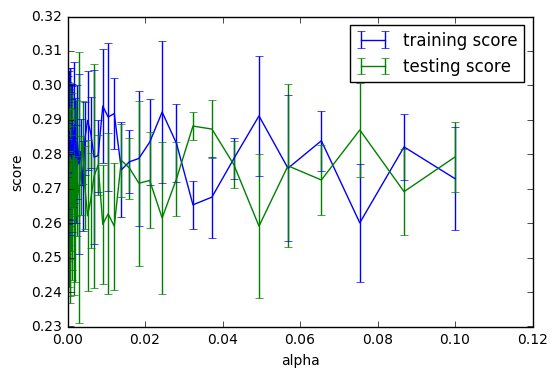

In [629]:
lasso = linear_model.Lasso
plot_overfit(df, target,lasso,{'alpha':np.logspace(-4,-1,50)})

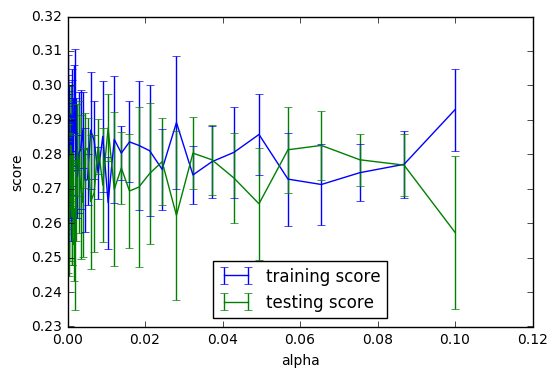

In [630]:
ridge = linear_model.Ridge
plot_overfit(df, target,ridge,{'alpha':np.logspace(-4,-1,50)})

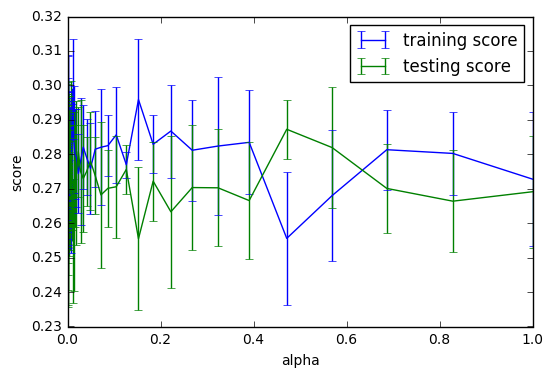

In [631]:
elastic = linear_model.ElasticNet
plot_overfit(df, target,elastic,{'alpha':np.logspace(-4,0,50)})

In [632]:
lasso = linear_model.Lasso()

parameters = {'normalize':(True,False),
              'alpha':np.logspace(-4,-.1,30)}
grid_searcher = grid_search.GridSearchCV(lasso, parameters)
grid_searcher.fit(df, target)

GridSearchCV(cv=None, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'normalize': (True, False), 'alpha': array([  1.00000e-04,   1.36296e-04,   1.85766e-04,   2.53191e-04,
         3.45089e-04,   4.70342e-04,   6.41057e-04,   8.73734e-04,
         1.19086e-03,   1.62310e-03,   2.21222e-03,   3.01516e-03,
         4.10954e-03,   5.60113e-03,   7.63411e-03...    1.68883e-01,   2.30181e-01,   3.13727e-01,   4.27597e-01,
         5.82797e-01,   7.94328e-01])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [633]:
grid_searcher.best_params_

{'alpha': 0.090911890647288357, 'normalize': False}

In [637]:
best_model = grid_searcher.best_estimator_
x = best_model.coef_

In [638]:
x

array([ 0.000734  ,  0.00711742, -0.01710677, -0.05233047])

In [635]:
avg_budget = float(1000000)
y = (np.exp(x) * avg_budget) - avg_budget
col = ('widest_release','days_in_release','new_releases_in_same_week','big_budget_same_week_release')
list(zip(col, y))

[('widest_release', 734.26684315910097),
 ('days_in_release', 7142.8099584663287),
 ('new_releases_in_same_week', -16961.280809729011),
 ('big_budget_same_week_release', -50984.805757445982)]

In [636]:
best_model.score(X_test,y_test)

0.27414251717734367